In [ ]:
import pandas as pd
import numpy as np
import torch
from nilearn.datasets import image, datasets
from neurovlm.data import data_dir
from neurovlm.coords import coords_to_vectors
from neurovlm.train import which_device
from neurovlm.retrieval_resources import _load_masker
device = which_device()

# Coordinate Smoothing

Use nimare to smooth coordinates with activation likelihood estimation (ALE). The result of this notebook is a 28542 vector per publication that represents coordinates reported in MNI space.

## Load

In [2]:
# Load
df_pubs = pd.read_parquet(data_dir / "publications.parquet")
df_coords = pd.read_parquet(data_dir / "coordinates.parquet")

# Sort
df_pubs = df_pubs.sort_values("pmid")
df_coords = df_coords.sort_values("pmid")

df_coords.shape, df_pubs.shape

((857298, 6), (30826, 5))

## Smoothing

Use a 9mm Gaussian kernel.

In [3]:
neuro_vectors = coords_to_vectors(df_coords, fwhm=9)

torch.save(
    {"neuro_vectors": neuro_vectors, "pmid": df_pubs["pmid"].to_numpy()},
    data_dir / "neuro_vectors.pt"
)

## Difumo Parcels

In [ ]:
from nilearn.maskers import NiftiMapsMasker

In [ ]:
if not (data_dir / "neuro_vectors_36mm.pt").exists():
    neuro_vectors = coords_to_vectors(df_coords, fwhm=36)
    torch.save(
        {"neuro_vectors": neuro_vectors, "pmid": df_pubs["pmid"].to_numpy()},
        data_dir / "neuro_vectors_36mm.pt"
    )
else:
    neuro_vectors, pmids = torch.load(
        data_dir / "neuro_vectors_36mm.pt", weights_only=False,
    ).values()

In [ ]:

def build_difumo_projection_matrix(difumo_masker, masker, device="cuda", dtype=torch.float32):
    """
    Builds P (n_vox, k) in mask space, and s = sum(P, dim=0).
    Requires difumo_masker and masker to already be aligned (same mask/space),
    and neuro_vectors to be in masker.transform() voxel order.
    """
    # Ensure difumo masker has resampled maps ready
    difumo_masker.fit()

    # Get maps image that difumo_masker is using after fit/resampling
    maps_img = difumo_masker.maps_img_  # nibabel-like img
    maps_4d = maps_img.get_fdata(dtype=np.float32)  # (X,Y,Z,k)

    # Mask in the same space/order as neuro_vectors (masker.transform output)
    mask_img = masker.mask_img_ if hasattr(masker, "mask_img_") else masker.mask_img
    mask = mask_img.get_fdata().astype(bool)

    # Flatten maps into (n_vox, k) in mask voxel order
    # NOTE: nilearn's masker uses C-order flattening; this matches get_fdata()[mask]
    P = maps_4d[mask, :]  # (n_vox, k)

    P = torch.as_tensor(P, device=device, dtype=dtype).contiguous()
    s = P.sum(dim=0).clamp_min(1e-12)  # avoid divide-by-zero

    return P, s

@torch.no_grad()
def difumo_project_voxels(X, P, s):
    """
    X: (..., n_vox) tensor (single vector or batch)
    P: (n_vox, k)
    s: (k,)
    Returns: (..., n_vox) reconstructed/projection result
    """
    # coefficients: (..., k)
    C = (X @ P) / s
    # reconstruction: (..., n_vox)
    X_hat = C @ P.T
    return X_hat

In [ ]:
# Load maskers
masker = _load_masker()
difumo = datasets.fetch_atlas_difumo(dimension=512)
atlas_img = image.load_img(difumo.maps)
atlas_img = image.resample_to_img(
    atlas_img, masker.mask_img,
    force_resample=True,
    interpolation="nearest",
    copy_header=True
)
difumo_masker = NiftiMapsMasker(atlas_img)

# Move onto gpu
X = neuro_vectors.to(device=device, dtype=torch.float32)

# Difumo projection
P, s = build_difumo_projection_matrix(difumo_masker, masker, device=device)
X_hat = difumo_project_voxels(X, P, s)

# Back to numpy
X_hat = X_hat.cpu().numpy()

# Percentile ceil
t = np.percentile(X_hat, 99, axis=1)
mask = t != 0
neuro_vectors_difumo = X_hat[mask] / t[mask, None]
neuro_vectors_difumo[neuro_vectors_difumo > 1.] = 1. # (n, 28542)

# Save
torch.save(
    {"neuro_vectors": torch.from_numpy(neuro_vectors_difumo), "pmid": pmids[mask]},
    data_dir / "neuro_vectors_difumo_proj.pt"
)

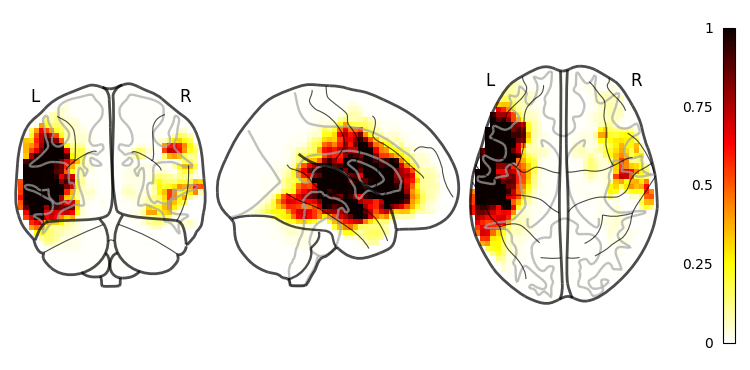

In [ ]:
from nilearn.plotting import plot_glass_brain
idx = 0
img = masker.inverse_transform(neuro_vectors_difumo[idx])
plot_glass_brain(img, threshold=0.)